In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' # I use a HiDPI screen

import os
import numpy as np
import matplotlib.pyplot as plt

# File Loading of PC/PS

This is slightly annoying because the `Om` is not the same. I have to do some string manipulation.
1. For each file in the PS directory, look for the counterpart in the PC directory.
2. Load the data into lists where for index i, PS[i] and PC[i] come from the same model.

In [2]:
# I'm running this locally, change to /tigress/jialiu/zack/ if you're on tigress
data_dir = '/Users/zequnl/Projects/neutrino_mpk/'
PS_directory = data_dir + 'powerspectrum'
PC_directory = data_dir + 'peakcounts'

# this code finds all the filenames and puts them in a list
PS_names, PC_names = [], []
for filename in os.listdir(PS_directory):
    if filename.endswith(".npy"): 
        PS_names.append(filename)
for filename in os.listdir(PC_directory):
    if filename.endswith(".npy"): 
        PC_names.append(filename)
print('Found', len(PS_names), 'PS files and', len(PC_names), 'PC files.')

def get_As( string_with_As ):
    return float(string_with_As.split('_As')[1].split('_mva')[0])

def get_filenames_PS_PC( input_As ):
    PS_filename_candidates = [x for x in PS_names if np.isclose(input_As,get_As(x), atol=1e-4)]
    PC_filename_candidates = [x for x in PC_names if np.isclose(input_As,get_As(x), atol=1e-4)]
    if len(PS_filename_candidates) == 1 and len(PC_filename_candidates) == 1:
        return PS_filename_candidates[0], PC_filename_candidates[0]
    else:
        print("multiple file candidates found! possibly fiducial model 1a/1b")
        return None

Found 101 PS files and 101 PC files.


In [3]:
from astropy.table import Table
t = Table.read(data_dir + 'cosmological_parameters.txt', format='ascii')

PS_filename_list_temp = []
PC_filename_list_temp = []
for row in t:
    # special cases (fiducial 1 and 2)
    if '1a(fiducial)' in row['Model']:
        PS_name = 'Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PS_50.npy'
        PC_name = 'Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S.npy'
    elif '1b(fiducial)' in row['Model']:
        PS_name = 'Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PS_50.npy'
        PC_name = 'Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PC_S.npy'
    else:
        PS_name, PC_name = get_filenames_PS_PC(row['10^9*A_s'])
    
    PS_filename_list_temp.append(PS_name)
    PC_filename_list_temp.append(PC_name)

# put the filenames in the table for easy access
t['PS'] = np.array(PS_filename_list_temp)
t['PC'] = np.array(PC_filename_list_temp)

# show the table
t

Model,M_nu(eV),Omega_m,10^9*A_s,sigma_8(derived),PS,PC
str12,float64,float64,float64,float64,str82,str81
1a(fiducial),0.0,0.3,2.1,0.8523,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PS_50.npy,Om0.29997_As2.10000_mva0.00000_mvb0.00000_mvc0.00000_h0.70000_Ode0.69995_PC_S.npy
1b(fiducial),0.1,0.3,2.1,0.8295,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PS_50.npy,Om0.29780_As2.10000_mva0.02175_mvb0.02338_mvc0.05486_h0.70000_Ode0.69995_PC_S.npy
2,0.06271,0.3815,2.2004,1.0135,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841_PS_50.npy,Om0.38016_As2.20037_mva0.00312_mvb0.00913_mvc0.05046_h0.70000_Ode0.61841_PC_S.npy
3,0.06522,0.2821,1.8826,0.7563,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790_PS_50.npy,Om0.28062_As1.88255_mva0.00479_mvb0.00983_mvc0.05059_h0.70000_Ode0.71790_PC_S.npy
4,0.06773,0.4159,1.6231,0.9171,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404_PS_50.npy,Om0.41442_As1.62306_mva0.00631_mvb0.01066_mvc0.05076_h0.70000_Ode0.58404_PC_S.npy
5,0.07024,0.2023,2.3075,0.6231,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_PS_50.npy,Om0.20080_As2.30753_mva0.00773_mvb0.01155_mvc0.05096_h0.70000_Ode0.79760_PC_S.npy
6,0.07275,0.3283,2.2883,0.9324,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169_PS_50.npy,Om0.32666_As2.28829_mva0.00908_mvb0.01249_mvc0.05118_h0.70000_Ode0.67169_PC_S.npy
7,0.07526,0.3355,1.5659,0.7828,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444_PS_50.npy,Om0.33386_As1.56595_mva0.01037_mvb0.01347_mvc0.05142_h0.70000_Ode0.66444_PC_S.npy
8,0.07778,0.2597,2.4333,0.8008,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029_PS_50.npy,Om0.25795_As2.43331_mva0.01163_mvb0.01446_mvc0.05169_h0.70000_Ode0.74029_PC_S.npy


## Computing Means and Covariance
We want to use prepare the mean PS and PC here. I just use a bunch of lists. I have to remove the elements which are 0, so I truncate the first 5 off.

In [4]:
PS_means = []
PC_means = []

for row in t:
    PS_arr = np.load( PS_directory + r'/' + row['PS'] )[:,5:]
    PC_arr = np.load( PC_directory + r'/' + row['PC'] )
    
    # first row of PS_arr is ell
    ell = PS_arr[0,:]
    PS_realizations = PS_arr[1:,:]
    # first and second row of PC are kappa, SNR
    kappa = PS_arr[0,:]
    SNR = PS_arr[1,:]
    PC_realizations = PC_arr[2:,:]
    
    if row['Model'] == '1a(fiducial)':
        print('shapes,',PS_realizations.shape, PC_realizations.shape)
        PS_cov = np.cov(PS_realizations.T)
        PC_cov = np.cov(PC_realizations.T)
    
    PS_means.append( np.mean(PS_realizations, axis=0) )
    PC_means.append( np.mean(PC_realizations, axis=0) )
    

shapes, (1000, 45) (1000, 200)


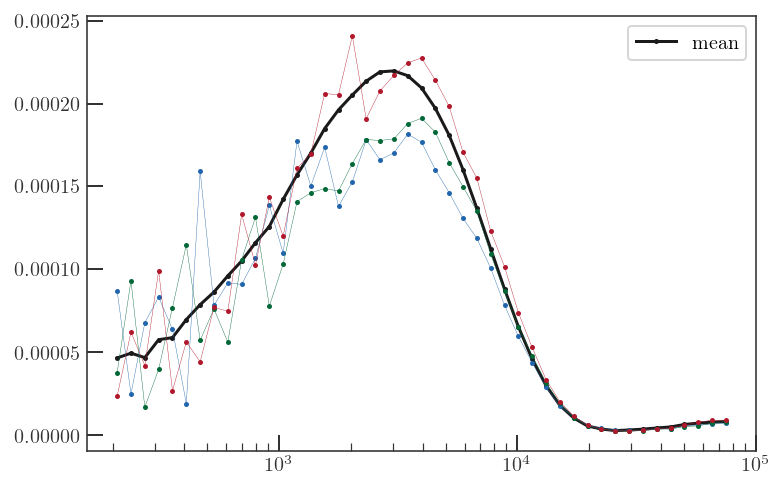

In [5]:
plt.plot( ell, ell*(ell+1)/np.pi * PS_means[0], label='mean' )

PS_arr = np.load( PS_directory + r'/' + t[0]['PS'] )[:,5:]
plt.plot( ell, ell*(ell+1)/np.pi * PS_arr[1], lw=0.2 )
plt.plot( ell, ell*(ell+1)/np.pi * PS_arr[2], lw=0.2 )
plt.plot( ell, ell*(ell+1)/np.pi * PS_arr[3], lw=0.2 )

plt.xscale('log')
plt.legend()
# plt.yscale('log')

## Interpolator

In [6]:
from forecast import buildInterpolator
obsarr = np.array( PS_means ) 
params = np.array( [t['M_nu(eV)'], t['Omega_m'], t['10^9*A_s']] ).T
print(obsarr.shape)
print(params.shape)

(101, 45)
(101, 3)


In [19]:
interp = buildInterpolator(obsarr, params)

## Probability Function
write down a probability function, where $P=\exp(-0.5(d-\mu)^{T}C^{-1}(d-u))$
 where d is the average PS/PC from the fiducial model (M_nu = 0.1 eV)

In [100]:
invcov = np.linalg.inv(PS_cov) 

def P( mu ):
    mu = interp( mu )
    # NOTE: 45 here means refers to bins-5, since first 5 are bad
    mu = np.array(list(mu.tolist())).reshape(45,) 
    d = obsarr[1]
    dm = d - mu
    return np.exp( -0.5 * np.dot(dm.T,np.dot(invcov,dm)) )  

# Testing the Interpolator
We plot the PS of two models (1b and 2), take the average of their cosmological parameters, and put them through the interpolator.

[ 0.1  0.3  2.1] [ 0.06271  0.3815   2.2004 ]


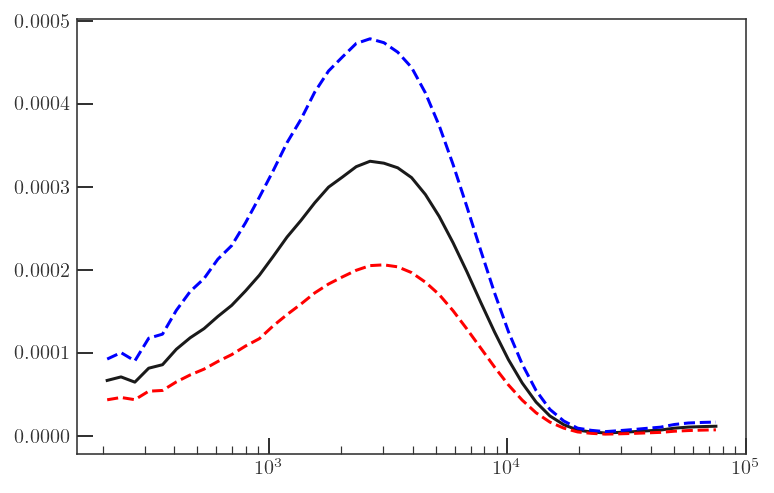

In [192]:
print(params[1], params[2])
mu = interp( (params[1] + params[2])/2. )
mu = np.array(list(mu.tolist())).reshape(45,) 

plt.plot(ell,ell*(ell+1)/np.pi * mu, '-')
plt.plot(ell,ell*(ell+1)/np.pi * obsarr[1], 'r--')
plt.plot(ell,ell*(ell+1)/np.pi * obsarr[2], 'b--')
plt.xscale('log')

## 1D cross sections
The 1D cross sections are sensibly right on top of our "observation". To make these, we fix the other two parameters at the "observation" (model 1b).

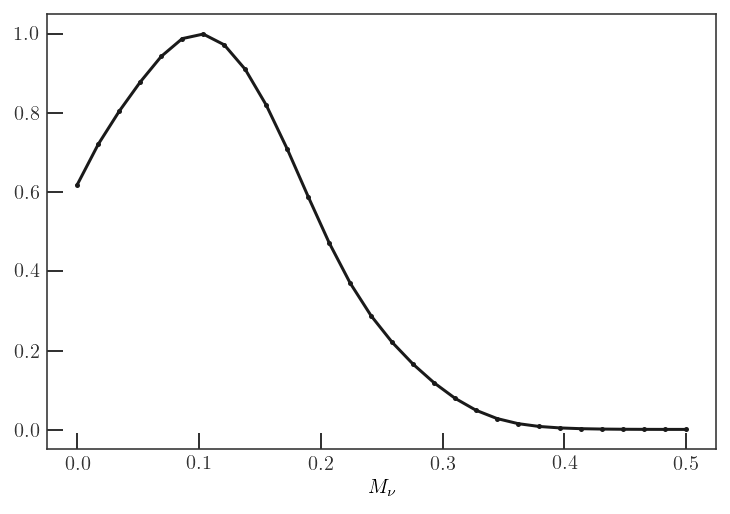

In [193]:
test_range = np.linspace(0.0, 0.5, 30)
plt.plot( test_range, [P( (p, 0.3, 2.1) ) for p in test_range] )
plt.xlabel(r'$M_{\nu}$')

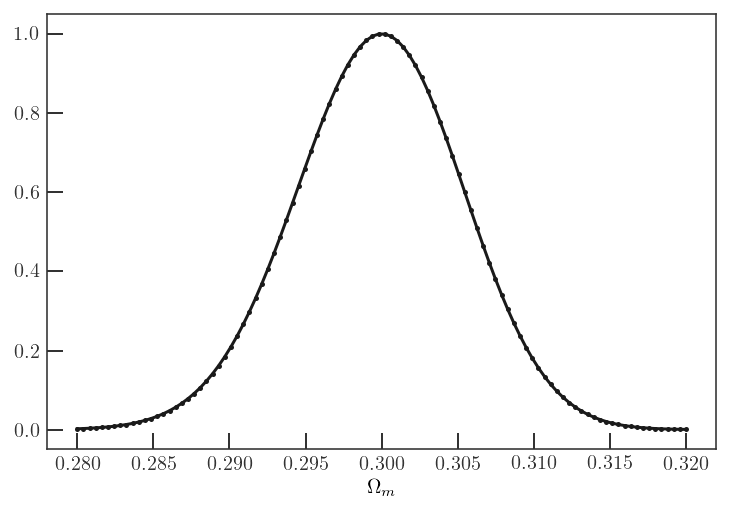

In [194]:
test_range = np.linspace(0.28, 0.32, 100)
plt.plot( test_range, [P( (0.1, p, 2.1) ) for p in test_range] )
plt.xlabel(r'$\Omega_m$')

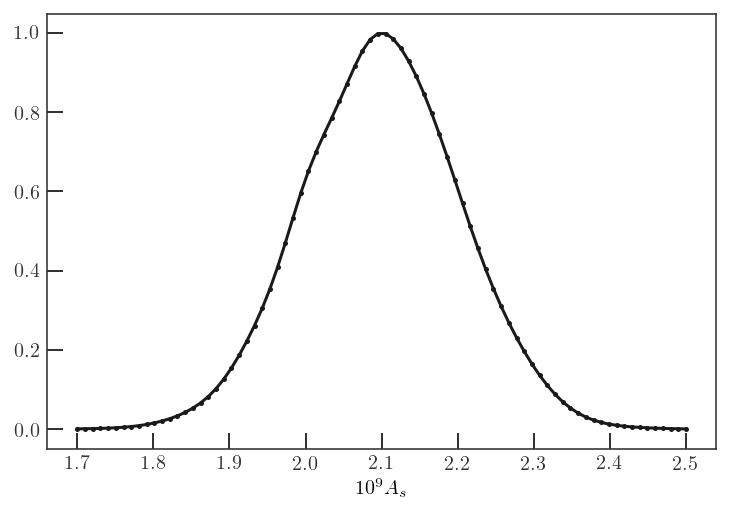

In [195]:
test_range = np.linspace(1.7, 2.5, 80)
plt.plot( test_range, [P( (0.1, 0.3, p) ) for p in test_range] )
plt.xlabel(r'$10^9A_s$')

# 2D slices
To test the interpolator further, we take 2D slices and fix just 1 parameter at the "observation" value.

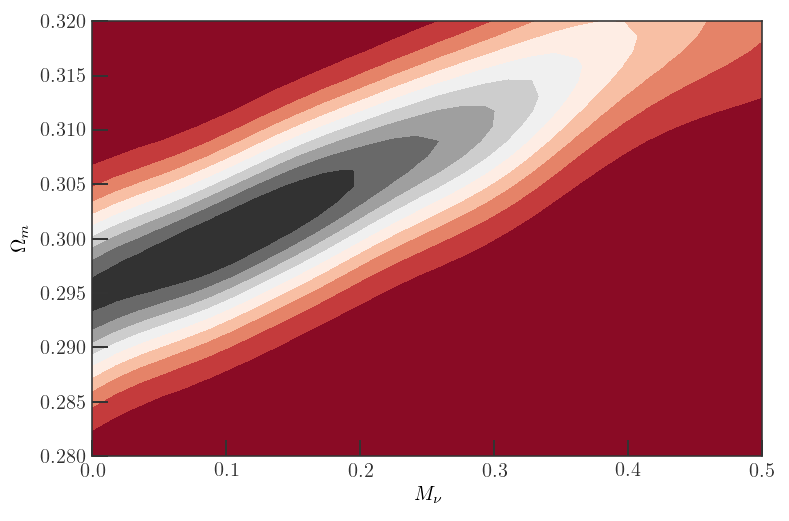

In [196]:
u = np.linspace(0.0, 0.5, 30)
v = np.linspace(0.28, 0.32, 30)
U, V = np.meshgrid(u, v)
P2 = np.array([P( (x,y,2.1) ) for x,y in zip(np.ravel(U), np.ravel(V))])
P2 = P2.reshape(U.shape)
plt.contourf(U, V, P2, 10, cmap='RdGy')
plt.xlabel(r'$M_{\nu}$')
plt.ylabel(r'$\Omega_m$')

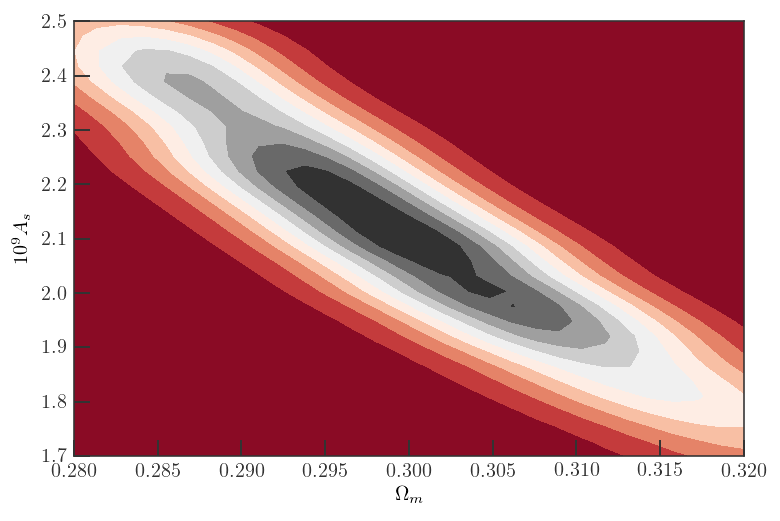

In [197]:
v = np.linspace(0.28, 0.32, 30)
w = np.linspace(1.7, 2.5, 30)

V, W = np.meshgrid(v, w)
P2 = np.array([P( (0.1,x,y) ) for x,y in zip(np.ravel(V), np.ravel(W))])
P2 = P2.reshape(U.shape)
plt.contourf(V, W, P2, 10, cmap='RdGy')

plt.xlabel(r'$\Omega_m$')
plt.ylabel(r'$10^9A_s$')

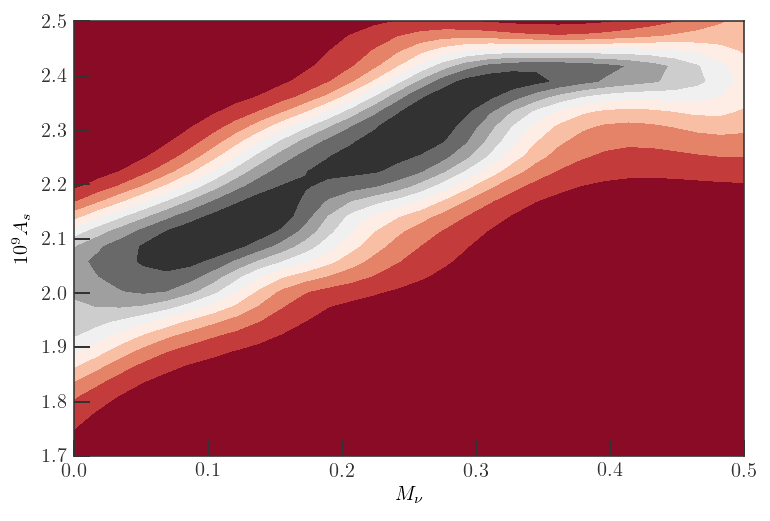

In [217]:
u = np.linspace(0.0, 0.5, 30)
w = np.linspace(1.7, 2.5, 30)

U, W = np.meshgrid(u, w)
P2 = np.array([P( (x,0.3,y) ) for x,y in zip(np.ravel(U), np.ravel(W))])
P2 = P2.reshape(U.shape)
plt.contourf(U, W, P2, 10, cmap='RdGy')

plt.xlabel(r'$M_{\nu}$')
plt.ylabel(r'$10^9A_s$')

## The plot above is problematic
The constraints above are a little problematic, since there seems to be a strong degeneracy. Planck 2015 does constrain $10^9 A_s < 2.2$ to about $2 \sigma$ but those constraints probably come from fixing the neutrino mass.

Specifically, the plot above predicts that the following two models should have the same power spectrum:

For parameters $(M_{\nu}, \Omega_m, 10^9 A_s)$,
* 1b. $(0.1, 0.3, 2.1)$
* a model with $(0.25, 0.3, 2.3)$
Let's see if that's true.

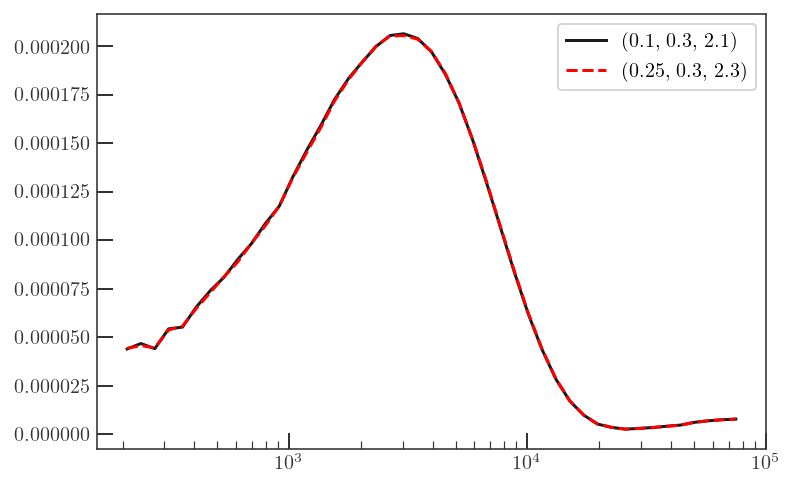

In [236]:


mu = interp( (0.1, 0.3, 2.1) )
mu = np.array(list(mu.tolist())).reshape(45,) 
plt.plot(ell,ell*(ell+1)/np.pi * mu, '-', label='(0.1, 0.3, 2.1)')

mu = interp( (0.25, 0.3, 2.3) )
mu = np.array(list(mu.tolist())).reshape(45,) 
plt.plot(ell,ell*(ell+1)/np.pi * mu, 'r--', label='(0.25, 0.3, 2.3)')

plt.xscale('log')
plt.legend()

# Which models are causing this?
Let's find out.

In [240]:
filter_for_03_Omegam = (t['Omega_m'] - 0.3)**2 < 0.02**2

filter_for_025_Mnu = (t['10^9*A_s'] - 2.3)**2 < 0.02**2
inds = np.where( np.logical_and(filter_for_03_Omegam, filter_for_025_Mnu) )

t[inds]

Model,M_nu(eV),Omega_m,10^9*A_s,sigma_8(derived),PS,PC
str12,float64,float64,float64,float64,str82,str81
26,0.124,0.3028,2.3174,0.8714,Om0.30010_As2.31745_mva0.03168_mvb0.03282_mvc0.05950_h0.70000_Ode0.69713_PS_50.npy,Om0.30010_As2.31745_mva0.03168_mvb0.03282_mvc0.05950_h0.70000_Ode0.69713_PC_S.npy
55,0.20837,0.2938,2.2978,0.825,Om0.28920_As2.29782_mva0.06341_mvb0.06399_mvc0.08098_h0.70000_Ode0.70617_PS_50.npy,Om0.28920_As2.29782_mva0.06341_mvb0.06399_mvc0.08098_h0.70000_Ode0.70617_PC_S.npy


It looks like model 55 is the best candidate for this region. And indeed when we plot it, we see that it matches model 1b very well,

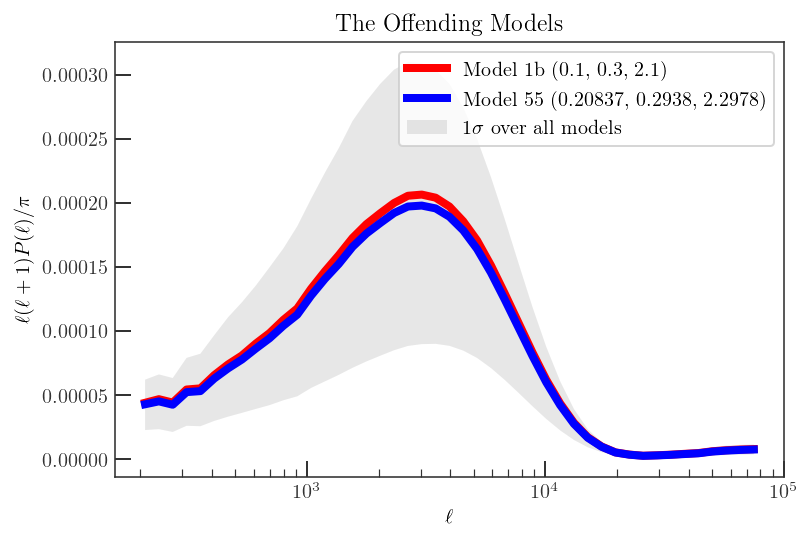

In [268]:
plt.gca().fill_between(ell, \
                      ell*(ell+1)/np.pi * (np.mean(obsarr, axis=0)-np.std(obsarr, axis=0)),\
                      ell*(ell+1)/np.pi * (np.mean(obsarr, axis=0)+np.std(obsarr, axis=0)),\
                      alpha=0.1, label=r'$1 \sigma$ over all models')

plt.plot(ell,ell*(ell+1)/np.pi * obsarr[1], 'r-', lw=4, label='Model 1b (0.1, 0.3, 2.1)' )
plt.plot(ell,ell*(ell+1)/np.pi * obsarr[55], 'b-', lw=4, label='Model 55 (0.20837, 0.2938, 2.2978)' )

plt.title('The Offending Models')
plt.ylabel(r'$\ell(\ell+1)P(\ell)/\pi$')
plt.xlabel(r'$\ell$')
plt.xscale('log')
plt.legend()

# Marginalizing Over Everything To Get Neutrino Mass
I just take the sum over the two axes that aren't neutrino mass.

In [212]:
u = np.linspace(0.0, 0.5, 30)
v = np.linspace(0.28, 0.32, 30)
w = np.linspace(1.7, 2.5, 30)

X, Y, Z = np.meshgrid(u, v, w)
Ps = np.array([P( (x,y,z) ) for x,y,z in zip(np.ravel(X), np.ravel(Y), np.ravel(Z))])
Ps = Ps.reshape(X.shape)

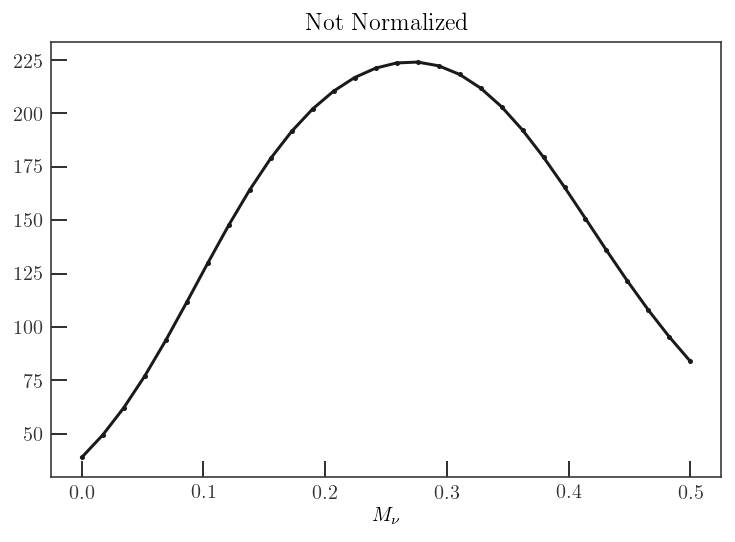

In [216]:
plt.plot( u, np.sum(np.sum(Ps, axis=2), axis=1) )
plt.xlabel(r'$M_{\nu}$')
plt.title('Not Normalized')